In [0]:
from google.colab import drive
drive.mount('/content/drive')

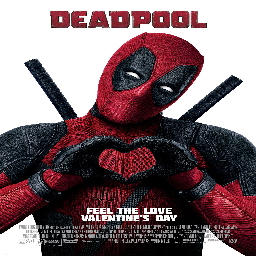


 Wade Wilson (Ryan Reynolds) is a former Special Forces operative who now works as a mercenary. 
His world comes crashing down when evil scientist Ajax (Ed Skrein) tortures, disfigures and transforms him into Deadpool. 
The rogue experiment leaves Deadpool with accelerated healing powers and a twisted sense of humor. 
With help from mutant allies Colossus and Negasonic Teenage Warhead (Brianna Hildebrand), Deadpool uses his new skills to hunt down the man who nearly destroyed his life. 

['Action', 'Crime', 'Drama', 'Thriller']


In [0]:
image_url = 'https://m.media-amazon.com/images/M/MV5BYzE5MjY1ZDgtMTkyNC00MTMyLThhMjAtZGI5OTE1NzFlZGJjXkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_.jpg'
plot = """Wade Wilson (Ryan Reynolds) is a former Special Forces operative who now works as a mercenary. 
His world comes crashing down when evil scientist Ajax (Ed Skrein) tortures, disfigures and transforms him into Deadpool. 
The rogue experiment leaves Deadpool with accelerated healing powers and a twisted sense of humor. 
With help from mutant allies Colossus and Negasonic Teenage Warhead (Brianna Hildebrand), Deadpool uses his new skills to hunt down the man who nearly destroyed his life."""
predict(image_url, plot, threshold = 0.3)

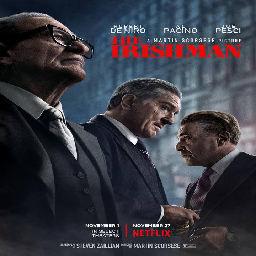


 In the 1950s, truck driver Frank Sheeran gets involved with Russell Bufalino and his Pennsylvania crime family. 
As Sheeran climbs the ranks to become a top hit man, he also goes to work for Jimmy Hoffa -- a powerful Teamster tied to organized crime. 

['Crime', 'Drama']


In [0]:
image_url = 'https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcT1OvwszdIz_Vc79PbB5El6tKdFdOGwHJZCOoKbbPVtyYZtyFC4'
plot = """In the 1950s, truck driver Frank Sheeran gets involved with Russell Bufalino and his Pennsylvania crime family. 
As Sheeran climbs the ranks to become a top hit man, he also goes to work for Jimmy Hoffa -- a powerful Teamster tied to organized crime."""
predict(image_url, plot, threshold = 0.3)

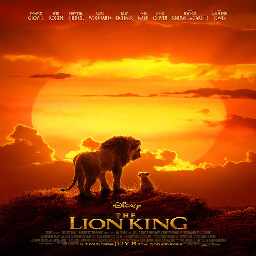


 Simba idolizes his father, King Mufasa, and takes to heart his own royal destiny on the plains of Africa. 
 But not everyone in the kingdom celebrates the new cub's arrival. Scar, Mufasa's brother -- and former heir to the throne -- has plans of his own. 
 The battle for Pride Rock is soon ravaged with betrayal, tragedy and drama, ultimately resulting in Simba's exile.
 Now, with help from a curious pair of newfound friends, Simba must figure out how to grow up and take back what is rightfully his. 

['Drama']


In [0]:
image_url = 'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcRuhgBlPlz9H3Y8hIyOVL0hMALI-t512zwqZZRdMJ4lw9q_NfMx'
plot = """Simba idolizes his father, King Mufasa, and takes to heart his own royal destiny on the plains of Africa. 
 But not everyone in the kingdom celebrates the new cub's arrival. Scar, Mufasa's brother -- and former heir to the throne -- has plans of his own. 
 The battle for Pride Rock is soon ravaged with betrayal, tragedy and drama, ultimately resulting in Simba's exile.
 Now, with help from a curious pair of newfound friends, Simba must figure out how to grow up and take back what is rightfully his."""
predict(image_url, plot, threshold = 0.3)

In [0]:
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display # to display images
import pandas as pd
import numpy as np
import torch

def predict(sample_image_url, sample_plot, threshold = 0.3) :

  label_names = np.asarray(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'], dtype = object)

  response = requests.get(sample_image_url)
  image = Image.open(BytesIO(response.content)).resize((256,256)).convert('RGB')

  plot = sample_plot 

  display(image)
  print("\n",plot,"\n")

  model = GMU(num_maxout_units = 10, hidden_layer_size = 1024, hidden_activation = None, dropout = 0.5).cuda()
  model.load_state_dict(torch.load('/content/drive/My Drive/dataset/model.pt'))


  df = pd.DataFrame(columns=['plot','image'])
  df.loc[len(df)] = [plot,image]


  text_embedding = GetTextEmbeddings_Bert(df)
  img_embedding = GetImageEmbeddings_VGG16(df)


  text_embedding.cuda()
  img_embedding.cuda()

  model.eval()
      
  with torch.no_grad():
    output = model(img_embedding.float(), text_embedding.float())

  predictions = (output > threshold).int()
  label_indices = (predictions == 1).squeeze(0).nonzero().cpu().numpy()
  print([item for sublist in label_names[label_indices] for item in sublist])


In [0]:
from torch import nn

#source: https://github.com/Duncanswilson/maxout-pytorch/blob/master/maxout_pytorch.ipynb
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))


class Maxout_MLP(nn.Module):
    def __init__(self, hidden_layer_size1, hidden_layer_size2, dropout, num_maxout_units=2):
        super(Maxout_MLP, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        self.hidden_layer_size1 = hidden_layer_size1
        self.hidden_layer_size2 = hidden_layer_size2
        for _ in range(num_maxout_units):
            self.fc1_list.append(nn.Linear(self.hidden_layer_size1, self.hidden_layer_size2))
            self.fc2_list.append(nn.Linear(self.hidden_layer_size2, self.hidden_layer_size2))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x): 
        x = x.view(-1, self.hidden_layer_size1)
        x = self.maxout(x, self.fc1_list)
        x = self.dropout(x)
        x = self.maxout(x, self.fc2_list)
        return x

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output


class GMU(nn.Module):

    def __init__(self, num_maxout_units = 2, hidden_layer_size = 512, text_embeddings_size = 3072, img_embeddings_size = 4096, num_labels = 23, hidden_activation = None, dropout = 0.1):

        super(GMU, self).__init__()
        self.num_labels = num_labels
        self.hidden_layer_size = hidden_layer_size

        self.linear_h_text = torch.nn.Linear(text_embeddings_size, self.hidden_layer_size, bias = False)
        self.linear_h_image = torch.nn.Linear(img_embeddings_size, self.hidden_layer_size, bias = False)
        self.linear_z = torch.nn.Linear(text_embeddings_size + img_embeddings_size, self.hidden_layer_size, bias = False)

        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

        self.dropout = nn.Dropout(p=dropout)
        self.linear = torch.nn.Linear(self.hidden_layer_size, self.num_labels)
        
        self.maxout = Maxout_MLP(self.hidden_layer_size, self.hidden_layer_size, dropout, num_maxout_units=num_maxout_units)

    def forward(self, image_embeddings, text_embeddings):
        
        image_h = self.linear_h_image(image_embeddings)
        image_h = self.tanh(image_h)
        text_h = self.linear_h_text(text_embeddings)
        text_h = self.tanh(text_h)
        concat = torch.cat((image_embeddings, text_embeddings), 1)
        z = self.linear_z(concat)
        z = self.sigmoid(z)
        gmu_output = z*image_h + (1-z)*text_h
        
        maxout_mlp_output = self.maxout(gmu_output)
        #dropped_layer = self.dropout(gmu_output)

        logits = self.linear(maxout_mlp_output)
        if(self.training) :
            return logits
        else :
            output = self.sigmoid(logits)
            return output



In [0]:
!pip install transformers
from transformers import BertModel, BertConfig
from torch import nn


class BertMultiLabelClassifier(nn.Module):

    def __init__(self, hidden_layer_size = 512, hidden_activation = "tanh", input_size = 3072, num_labels = 23, dropout = 0.1, gen_embeddings = False, use_pooled_output = False):

        super(BertMultiLabelClassifier, self).__init__()
        self.num_labels = num_labels
        self.input_size = input_size
        self.gen_embeddings = gen_embeddings
        self.hidden_layer_size = hidden_layer_size
        self.use_pooled_output = use_pooled_output

        if(self.use_pooled_output) :
            self.base_model = BertModel.from_pretrained('bert-base-uncased') #to generate embedding size of 768
        else :
            config = BertConfig.from_pretrained('bert-base-uncased')
            config.output_hidden_states=True
            self.base_model = BertModel.from_pretrained('bert-base-uncased', config=config) #to generate embedding size of 3072 by concatenating last four layers
        
        self.hidden_layer1 = torch.nn.Linear(self.input_size, self.hidden_layer_size)        
        if(hidden_activation == "tanh") :
          self.hidden_activation1 = torch.nn.Tanh()
          self.hidden_activation2 = torch.nn.Tanh()
        elif(hidden_activation == "relu") :
          self.hidden_activation1 = torch.nn.ReLU()
          self.hidden_activation2 = torch.nn.Tanh()
        elif(hidden_activation == "sigmoid") :
          self.hidden_activation1 = torch.nn.Sigmoid()
          self.hidden_activation2 = torch.nn.Tanh()
        elif(hidden_activation == "leaky_relu") :
          self.hidden_activation1 = torch.nn.LeakyReLU()
          self.hidden_activation2 = torch.nn.Tanh()
        else :
          return("Invalid hidden_activation parameter value.")

        self.hidden_layer2 = torch.nn.Linear(self.hidden_layer_size, self.hidden_layer_size)

        self.output_layer = torch.nn.Linear(self.hidden_layer_size, self.num_labels)
        self.output_activation = torch.nn.Sigmoid()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, indexed_tokens, segment_ids=None, masked_ids=None):
        
        if(self.gen_embeddings):
            if(self.use_pooled_output) :
                pooled_output = self.base_model(indexed_tokens, segment_ids, masked_ids)
                embeddings = pooled_output[1]
                return embeddings
            else:
                output = self.base_model(indexed_tokens, segment_ids, masked_ids)
                embeddings = torch.cat((output[-1][-1],output[-1][-2],output[-1][-3],output[-1][-4]), dim = 2).mean(1)
                return embeddings
        else :
            embeddings = indexed_tokens
        
        logits1 = self.hidden_layer1(embeddings)
        activation1 = self.hidden_activation1(logits1)

        dropped1 = self.dropout(activation1)

        logits2 = self.hidden_layer2(dropped1)
        activation2 = self.hidden_activation2(logits2)

        dropped2 = self.dropout(activation2)

        logits3 = self.output_layer(dropped2)
        if(self.training) :
            return logits3
        else :
            output = self.output_activation(logits3)
            return output


    def freeze_base_model(self):
        for param in self.base_model.parameters():
            param.requires_grad = False


    def unfreeze_base_model(self):
        for param in self.base_model.named_parameters():
            param.requires_grad = True

     |████████████████████████████████| 450kB 2.8MB/s 
     |████████████████████████████████| 1.0MB 12.0MB/s 
     |████████████████████████████████| 870kB 19.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884629 sha256=92e3e171339df6164d951afb6c868c0c2464ca184b3b11ad92a6a4b4af19cae7
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
import torch
from torch import nn
from torchvision import models, transforms

class VGG16MultiLabelClassifier(nn.Module):
  
  def __init__(self, hidden_layer_size = 512, hidden_activation = "tanh", input_size = 4096, num_labels = 23, dropout = 0.1, gen_embeddings = False):

        super(VGG16MultiLabelClassifier,self).__init__()
        self.num_labels = num_labels
        self.input_size = input_size
        self.base_model = models.vgg16()
        self.hidden_layer_size = hidden_layer_size
        self.gen_embeddings = gen_embeddings
        self.embedding_layers = list(self.base_model.classifier.children())[:-2] 
        self.base_model.classifier = nn.Sequential(*self.embedding_layers)

        self.hidden_layer1 = torch.nn.Linear(self.input_size, self.hidden_layer_size)        
        if(hidden_activation == "tanh") :
          self.hidden_activation1 = torch.nn.Tanh()
          self.hidden_activation2 = torch.nn.Tanh()
        elif(hidden_activation == "relu") :
          self.hidden_activation1 = torch.nn.ReLU()
          self.hidden_activation2 = torch.nn.Tanh()
        elif(hidden_activation == "sigmoid") :
          self.hidden_activation1 = torch.nn.Sigmoid()
          self.hidden_activation2 = torch.nn.Tanh()
        elif(hidden_activation == "leaky_relu") :
          self.hidden_activation1 = torch.nn.LeakyReLU()
          self.hidden_activation2 = torch.nn.Tanh()
        else :
          return("Invalid hidden_activation parameter value.")

        self.hidden_layer2 = torch.nn.Linear(self.hidden_layer_size, self.hidden_layer_size)

        self.output_layer = torch.nn.Linear(self.hidden_layer_size, self.num_labels)
        self.output_activation = torch.nn.Sigmoid()

        self.dropout = nn.Dropout(p=dropout)


  def forward(self, input):
        
        if(self.gen_embeddings):
            embeddings = self.base_model(input)
            return embeddings
        else :
            embeddings = input
        
        logits1 = self.hidden_layer1(embeddings)
        activation1 = self.hidden_activation1(logits1)

        dropped1 = self.dropout(activation1)

        logits2 = self.hidden_layer2(dropped1)
        activation2 = self.hidden_activation2(logits2)

        dropped2 = self.dropout(activation2)

        logits3 = self.output_layer(dropped2)
        if(self.training) :
            return logits3
        else :
            output = self.output_activation(logits3)
            return output


  def freeze_base_model(self):
        for param in self.base_model.features.parameters():
            param.requires_grad = False


  def unfreeze_base_model(self):
        for param in self.base_model.features.parameters():
            param.requires_grad = True
        

In [0]:
import torch
from torch.utils.data import DataLoader, SequentialSampler

def GetImageEmbeddings_VGG16(dataset, batch_size = 32):
  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  image_tensors = ImageTransformation_VGG16(dataset['image'])
  sampler = SequentialSampler(image_tensors)
  dataloader = DataLoader(image_tensors, sampler=sampler, batch_size=batch_size)
  
  results = torch.Tensor().to(device)

  model = VGG16MultiLabelClassifier(gen_embeddings = True)
  model.to(device)
  model.eval()

  for num, batch_data in enumerate(dataloader): 
      #print(num)   
      data = batch_data.to(device)
      with torch.no_grad():
        emdeddings = model(data)
      results = torch.cat((results, emdeddings))

  return results


from torch.utils.data import Dataset

class ImageTransformation_VGG16(Dataset) :

    def __init__(self, PIL_images_list, train = True):

        self.PIL_images_list = PIL_images_list
        self.train = train

        '''
        self.transformations_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        '''

        self.transformations_train = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


        self.transformations_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.PIL_images_list)

    def __getitem__(self, idx):

        if self.train:
            sample = self.transformations_train(self.PIL_images_list[idx])
        else:
            sample = self.transformations_test(self.PIL_images_list[idx])
        return sample



import torch
from torch.utils.data import DataLoader, SequentialSampler

def GetTextEmbeddings_Bert(dataset, batch_size = 32):
  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  input_ids = TextTransformation_Bert(dataset['plot'])
  sampler = SequentialSampler(input_ids)
  dataloader = DataLoader(input_ids, sampler=sampler, batch_size=batch_size)
  
  results = torch.Tensor().to(device)

  model = BertMultiLabelClassifier(gen_embeddings = True)
  model.to(device)
  model.eval()

  for num, batch_data in enumerate(dataloader):
      #print(num) 
      indexed_tokens, segment_ids , masked_ids = tuple(t for t in batch_data)   
      data = indexed_tokens.to(device)
      with torch.no_grad():
        emdeddings = model(data)
      results = torch.cat((results, emdeddings))

  return results



import nltk
from transformers import BertTokenizer
from nltk import tokenize
#nltk.download('punkt')
from torch.utils.data import Dataset

class TextTransformation_Bert(Dataset) :

    def __init__(self, text_list, max_input_length = 512):

        self.text_list = text_list
        self.indexed_tokens = []
        self.segment_ids = []
        self.masked_ids = []
        self.max_input_length = max_input_length

    def GetIndexedTokens(self, text):
        
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        tokenized_text = tokenizer.tokenize(text)
        tokenized_text.append("[SEP]")
        tokenized_text.insert(0,"[CLS]")
        self.indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
        

    def GetSegmentIds(self) :
        
        self.segment_ids = [1] * len(self.indexed_tokens)

 
    def GetMaskedIds(self) :
        
        self.masked_ids = [1] * len(self.indexed_tokens)


    def Padding(self) :

        if(len(self.indexed_tokens) < self.max_input_length) :
           padding = [0]*(self.max_input_length - len(self.indexed_tokens))
           self.indexed_tokens += padding
           self.segment_ids += padding
           self.masked_ids += padding
        else :
           del self.indexed_tokens[self.max_input_length:]
           del self.segment_ids[self.max_input_length:]
           del self.masked_ids[self.max_input_length:]

    def __len__(self):
        return len(self.text_list)


    def __getitem__(self, idx):

        text = self.text_list[idx]

        self.GetIndexedTokens(text)
        self.GetSegmentIds()
        self.GetMaskedIds()
        self.Padding()
        
        self.indexed_tokens = torch.tensor(self.indexed_tokens)
        self.segment_ids = torch.tensor(self.segment_ids)
        self.masked_ids = torch.tensor(self.masked_ids)
        
        return self.indexed_tokens, self.segment_ids , self.masked_ids


